In [120]:
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.preprocessing import OneHotEncoder,StandardScaler,PolynomialFeatures,RobustScaler
from sklearn.linear_model import Ridge,LinearRegression,Lasso,ElasticNet
from sklearn.pipeline import make_pipeline
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV,learning_curve, RandomizedSearchCV
from sklearn.dummy import DummyRegressor
import pickle

In [121]:
df = pd.read_csv("dataset_clear.csv")

In [122]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'cat_bmi'],
      dtype='object')

In [123]:
feature = df.columns[0:-1]
target = 'charges'
X =df.drop(["charges","bmi"],axis=1)
y = df[target]



In [124]:
X.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1337 entries, 0 to 1336
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   age       1337 non-null   int64 
 1   sex       1337 non-null   object
 2   children  1337 non-null   int64 
 3   smoker    1337 non-null   object
 4   region    1337 non-null   object
 5   cat_bmi   1337 non-null   object
dtypes: int64(2), object(4)
memory usage: 62.8+ KB


In [125]:
X_train, X_test, y_train, y_test = train_test_split(X, y,shuffle=True, random_state=42, train_size = 0.8,stratify=X['smoker'])

In [126]:
dummy = DummyRegressor()

In [127]:
numerical_features = [
       'age'
       ]
categorical_features = [
       'sex' , 'smoker', 'region','cat_bmi','children'
       ]



In [128]:


my_col_trans = ColumnTransformer([
    ("sclal",StandardScaler(),numerical_features),
    
    ("one_hot_encoder",OneHotEncoder(handle_unknown='ignore'),categorical_features),
    
])



In [129]:
X_train.head()

,age,sex,children,smoker,region,cat_bmi
367,42,female,2,no,northwest,healthy
418,64,male,1,no,southeast,obesity
938,53,male,0,no,southeast,overweight
533,37,male,0,no,southeast,obesity
354,18,female,0,no,southeast,obesity


In [130]:
dummy.fit(X_train,y_train)
dummy.score(X_train,y_train)

0.0

In [131]:
dummy.score(X_test,y_test)

-0.0010185684988295307

In [132]:
truc=make_pipeline(my_col_trans,PolynomialFeatures(degree=2), ElasticNet(max_iter=100000,random_state=42))
truc.get_params()

{'memory': None,
 'steps': [('columntransformer',
   ColumnTransformer(transformers=[('sclal', StandardScaler(), ['age']),
                                   ('one_hot_encoder',
                                    OneHotEncoder(handle_unknown='ignore'),
                                    ['sex', 'smoker', 'region', 'cat_bmi',
                                     'children'])])),
  ('polynomialfeatures', PolynomialFeatures()),
  ('elasticnet', ElasticNet(max_iter=100000, random_state=42))],
 'verbose': False,
 'columntransformer': ColumnTransformer(transformers=[('sclal', StandardScaler(), ['age']),
                                 ('one_hot_encoder',
                                  OneHotEncoder(handle_unknown='ignore'),
                                  ['sex', 'smoker', 'region', 'cat_bmi',
                                   'children'])]),
 'polynomialfeatures': PolynomialFeatures(),
 'elasticnet': ElasticNet(max_iter=100000, random_state=42),
 'columntransformer__n_jobs': None,


In [133]:
modelElastic= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), ElasticNet(max_iter=100000,random_state=42))
parameters = {"elasticnet__alpha":np.linspace(0.09,0.2,50),"elasticnet__l1_ratio":np.arange(0.81,0.82,0.001)}

randm_src = GridSearchCV(estimator=modelElastic, param_grid=parameters,scoring='r2',cv = 5)
randm_src.fit(X_train, y_train)


modelElastic.set_params(**randm_src.best_params_)
print(randm_src.best_params_)
best=randm_src.best_params_

{'elasticnet__alpha': 0.09, 'elasticnet__l1_ratio': 0.8190000000000001}


In [134]:
best
#best=49

{'elasticnet__alpha': 0.09, 'elasticnet__l1_ratio': 0.8190000000000001}

In [135]:
modelElastic= make_pipeline(my_col_trans,PolynomialFeatures(degree=2), ElasticNet(alpha=best['elasticnet__alpha'],l1_ratio=best['elasticnet__l1_ratio'],max_iter=100000,random_state=42))
modelElastic.fit(X_train,y_train)
modelElastic.score(X_train,y_train)


0.8558852276555886

In [136]:
modelElastic.score(X_test,y_test)

0.9052072430926748

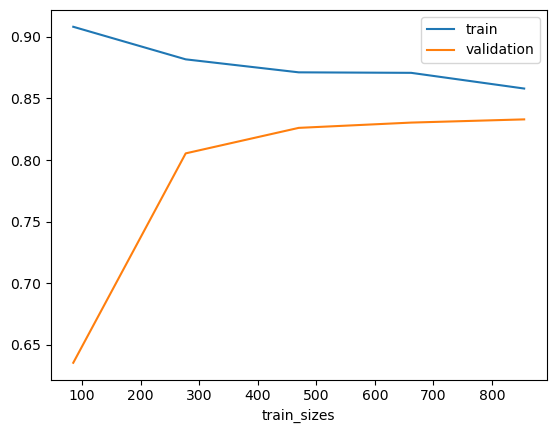

In [137]:
train_sizes, train_scores, test_scores = learning_curve(modelElastic,X_train,y_train)                                         
                                           
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [138]:
y_pred = modelElastic.predict(X_train)

In [139]:
residual = (y_pred - y_train).abs().sort_values()

In [140]:
residual.describe()

count     1069.000000
mean      2666.149920
std       3755.972959
min          3.484643
25%        873.063341
50%       1568.521781
75%       2473.309285
max      23872.268152
Name: charges, dtype: float64

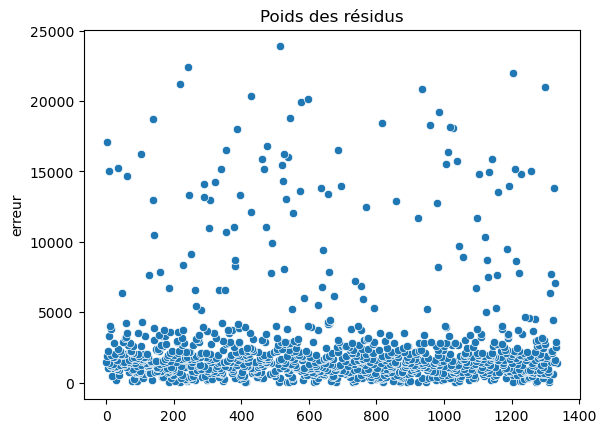

In [141]:


sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()



In [142]:
residual.quantile(0.91)

6569.620956890265

In [143]:
to_drop = residual[residual > 10000].index

In [144]:
X_train.loc[to_drop]

,age,sex,children,smoker,region,cat_bmi
1122,27,female,1,no,northeast,obesity
143,29,male,2,no,northwest,overweight
354,18,female,0,no,southeast,obesity
305,29,male,2,no,northwest,obesity
473,47,female,0,no,northeast,obesity
...,...,...,...,...,...,...
1299,45,male,0,yes,southeast,obesity
219,24,female,0,no,southeast,healthy
1205,59,female,2,no,southwest,obesity
242,55,female,1,no,southwest,overweight


In [145]:
y_train.loc[to_drop]

1122    18903.49141
143     18157.87600
354     14133.03775
305     19442.35350
473     20878.78443
           ...     
1299    62592.87309
219     25081.76784
1205    36910.60803
242     35160.13457
516     27724.28875
Name: charges, Length: 69, dtype: float64

In [146]:
to_drop=X_train.loc[to_drop][X_train.loc[to_drop]["smoker"]== "no"].index

In [147]:


X_train = X_train.drop(to_drop)
y_train = y_train.drop(to_drop)



In [148]:


modelElastic.fit(X_train,y_train)
modelElastic.score(X_train,y_train)



0.9564705145080707

In [149]:


modelElastic.score(X_test,y_test)



0.910833959421104

In [150]:
y_pred = modelElastic.predict(X_train)

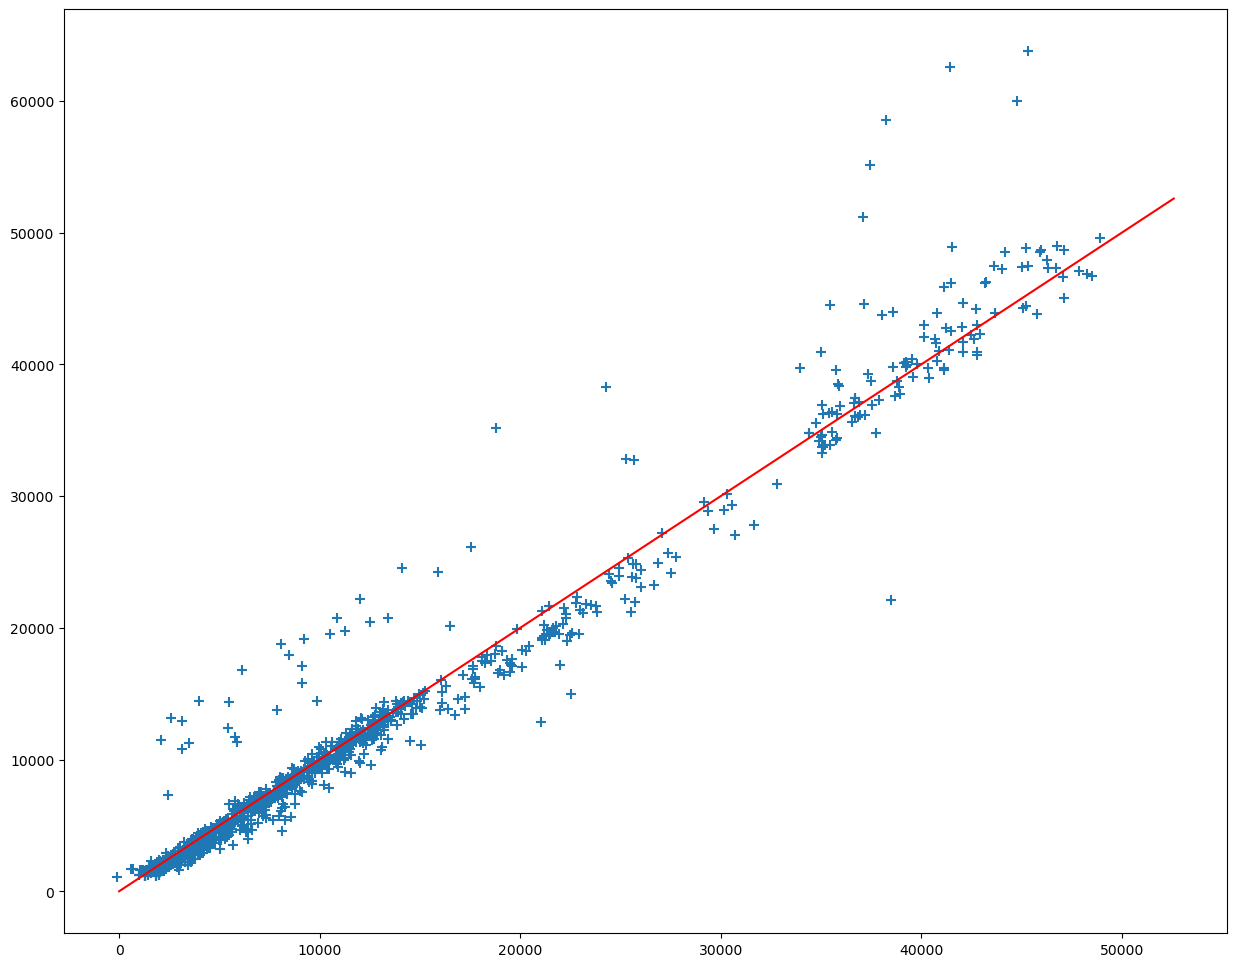

In [151]:
plt.subplots(figsize=(15, 12))
plt.scatter(y_pred,y_train,marker="+",s=50)
plt.plot(np.arange(max(y_test.values)), np.arange(max(y_test.values)), '-', color='r')

In [152]:
residual = (y_pred - y_train).abs().sort_values()

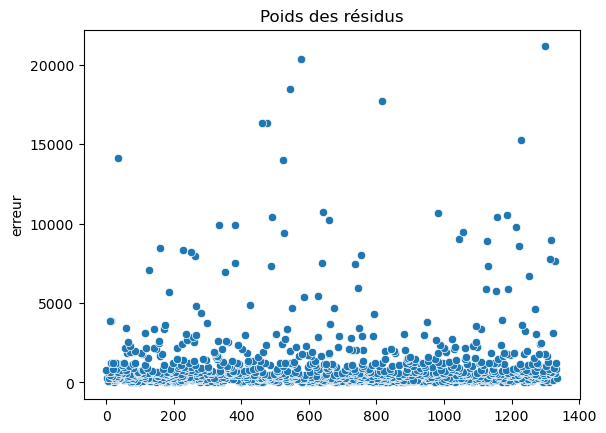

In [153]:
sns.scatterplot(residual)
plt.title('Poids des résidus')
plt.ylabel('erreur')
plt.show()

In [154]:
residual.describe()

count     1009.000000
mean      1183.693888
std       2230.814335
min          0.021057
25%        241.850123
50%        549.275886
75%       1136.280073
max      21139.968800
Name: charges, dtype: float64

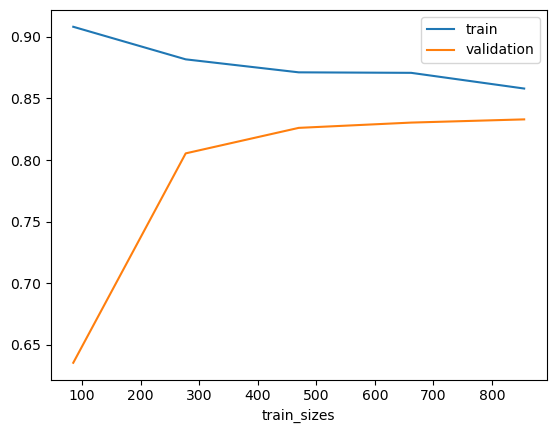

In [155]:
plt.plot(train_sizes, train_scores.mean(axis=1), label='train')
plt.plot(train_sizes, test_scores.mean(axis=1), label='validation')
plt.xlabel('train_sizes')
plt.legend()
plt.show()

In [156]:
pickle_out = open("modelElastic.pkl", "wb") 
pickle.dump(modelElastic, pickle_out) 
pickle_out.close()